<a href="https://colab.research.google.com/github/HiGiangcoder/jupyter_notebook/blob/master/Assignment0_MCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đây là code demo Decision Tree sử dụng thuật toán ID3.

## Khai báo các thư viện cần thiết

In [1]:
!pip install graphviz

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from graphviz import Digraph
from IPython.display import display

## Xây dựng Entropy và Information Gain

In [3]:
def entropy(y):
    vals, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def information_gain(X_col, y):
    base = entropy(y)
    vals, counts = np.unique(X_col, return_counts=True)
    n = len(y)
    cond = 0.0
    for v in vals:
        y_sub = y[X_col == v]
        cond += (len(y_sub)/n) * entropy(y_sub)
    return base - cond

## Node định nghĩa cây

In [4]:
class Node:
    def __init__(self, feature_index=None, threshold=None,
                 left=None, right=None,
                 children=None, prediction=None, depth=0):
        self.feature_index = feature_index
        self.threshold = threshold  # continuous split
        self.left = left
        self.right = right
        self.children = children if children is not None else {}  # categorical split
        self.prediction = prediction
        self.depth = depth

    def is_leaf(self):
        return self.prediction is not None


In [5]:
def best_split(X, y, feature_indices):
    from math import log2
    def entropy(y):
        counts = np.bincount(y)
        probs = counts[counts > 0] / len(y)
        return -np.sum(probs * np.log2(probs))

    base_entropy = entropy(y)
    best_gain, best_feature, best_threshold = -1, None, None

    for fi in feature_indices:
        values = np.unique(X[:, fi])
        if len(values) <= 1:
            continue
        thresholds = (values[:-1] + values[1:]) / 2.0
        for t in thresholds:
            left = y[X[:, fi] <= t]
            right = y[X[:, fi] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            gain = base_entropy - (
                len(left)/len(y)*entropy(left) + len(right)/len(y)*entropy(right)
            )
            if gain > best_gain:
                best_gain, best_feature, best_threshold = gain, fi, t

    return best_feature, best_threshold, best_gain


## Hàm ID3 đệ quy

In [6]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                 prediction=None, depth=0):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.prediction = prediction
        self.depth = depth

    def is_leaf(self):
        return self.prediction is not None


def best_split(X, y, feature_indices):
    best_gain = -np.inf
    best_feature, best_thresh = None, None

    base_entropy = entropy(y)
    n = len(y)

    for fi in feature_indices:
        values = np.unique(X[:, fi])
        if len(values) <= 1:
            continue

        # thử ngưỡng giữa các giá trị liên tiếp
        thresholds = (values[:-1] + values[1:]) / 2.0
        for t in thresholds:
            left_mask = X[:, fi] <= t
            right_mask = ~left_mask
            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            # entropy sau split
            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])
            gain = base_entropy - (
                left_mask.mean() * left_entropy + right_mask.mean() * right_entropy
            )

            if gain > best_gain:
                best_gain = gain
                best_feature = fi
                best_thresh = t

    return best_feature, best_thresh, best_gain


def id3(X, y, feature_indices, depth=0, max_depth=None, min_samples=2):
    uniq = np.unique(y)
    if len(uniq) == 1:
        return Node(prediction=int(uniq[0]), depth=depth)
    if len(feature_indices) == 0 or len(y) < min_samples or \
       (max_depth is not None and depth >= max_depth):
        return Node(prediction=int(Counter(y).most_common(1)[0][0]), depth=depth)

    best_f, best_t, best_g = best_split(X, y, feature_indices)
    if best_f is None or best_g <= 0:
        return Node(prediction=int(Counter(y).most_common(1)[0][0]), depth=depth)

    node = Node(feature_index=best_f, threshold=best_t, depth=depth)
    left_mask = X[:, best_f] <= best_t
    right_mask = ~left_mask

    node.left = id3(X[left_mask], y[left_mask], feature_indices,
                               depth+1, max_depth, min_samples)
    node.right = id3(X[right_mask], y[right_mask], feature_indices,
                                depth+1, max_depth, min_samples)
    return node


## Hàm plot_tree

In [7]:
def plot_tree(node, feature_names, filename="id3_tree"):
    dot = Digraph()
    dot.attr("node", shape="box", style="rounded, filled", color="lightblue2", fontname="Helvetica")

    def add_nodes_edges(node, parent=None, edge_label=""):
        if node.prediction is not None:
            # Node lá
            label = f"Leaf: class={node.prediction}"
            dot.node(str(id(node)), label=label, shape="ellipse", color="lightgreen")
        else:
            # Node phân nhánh: thêm tên feature + điều kiện nếu có
            label = f"{node.feature}"
            dot.node(str(id(node)), label=label)

        if parent is not None:
            dot.edge(str(id(parent)), str(id(node)), label=edge_label)

        if node.children:
            for val, child in node.children.items():
                # Thêm điều kiện rõ ràng (ví dụ Feature=Value)
                cond_label = f"{node.feature} = {val}"
                add_nodes_edges(child, node, edge_label=cond_label)

    add_nodes_edges(node)
    dot.render(filename, format="png", cleanup=True)
    print(f"✅ Cây đã được vẽ và lưu tại: {filename}.png")


def plot_tree_graphviz(node, dot=None):
    if dot is None:
        dot = Digraph()
        dot.attr("node", shape="box", style="rounded,filled", color="lightblue2")

    if node.prediction is not None:
        dot.node(str(id(node)), f"Leaf: class={node.prediction}", shape="ellipse", color="lightgreen")
    else:
        # Nếu có threshold (numerical split)
        if node.threshold is not None:
            label = f"{node.feature} <= {node.threshold}\ndepth={node.depth}"
        else:
            # Nếu categorical split
            label = f"{node.feature}\ndepth={node.depth}"
        dot.node(str(id(node)), label)

        for value, child in node.children.items():
            plot_tree_graphviz(child, dot)
            # Nếu categorical split -> hiển thị "feature=value"
            dot.edge(str(id(node)), str(id(child)), label=str(value))

    return dot



In [8]:
def tree_to_graphviz(node, feature_names, dot=None, parent=None, edge_label=""):
    if dot is None:
        dot = Digraph()
        dot.attr("node", shape="box", style="rounded,filled", color="lightblue2", fontname="Helvetica")

    if node.is_leaf():
        dot.node(str(id(node)), f"Leaf: class={node.prediction}", shape="ellipse", color="lightgreen")
    else:
        # hiển thị feature + threshold
        label = f"{feature_names[node.feature_index]} <= {node.threshold:.3f}\ndepth={node.depth}"
        dot.node(str(id(node)), label)

    if parent is not None:
        dot.edge(str(id(parent)), str(id(node)), label=edge_label)

    if not node.is_leaf():
        # left branch
        if node.left is not None:
            tree_to_graphviz(node.left, feature_names, dot, node, edge_label=f"<= {node.threshold:.3f}")
        # right branch
        if node.right is not None:
            tree_to_graphviz(node.right, feature_names, dot, node, edge_label=f"> {node.threshold:.3f}")

    return dot

## Hàm dự đoán

In [9]:
def predict_one(node, x):
    cur = node
    while not cur.is_leaf():
        fi = cur.feature_index
        val = x[fi]
        if cur.threshold is not None:
            # continuous split
            if val <= cur.threshold:
                cur = cur.left
            else:
                cur = cur.right
        else:
            # categorical fallback (nếu có)
            if val in cur.children:
                cur = cur.children[val]
            else:
                preds = collect_leaf_predictions(cur)
                return int(Counter(preds).most_common(1)[0][0])
    return int(cur.prediction)

def predict(node, X):
    return np.array([predict_one(node, x) for x in X])


## Hàm Prune

In [10]:
def reduced_error_prune(node, X_train, y_train, X_val, y_val):
    """
    Post-pruning: thử thay các node con bằng leaf (majority class),
    nếu accuracy trên validation không giảm thì chấp nhận prune.
    """
    def collect_nodes(n):
        res = []
        if not n.is_leaf():
            if n.left:
                res.extend(collect_nodes(n.left))
            if n.right:
                res.extend(collect_nodes(n.right))
            res.append(n)  # post-order
        return res

    nodes = collect_nodes(node)

    best_acc = accuracy_score(y_val, predict(node, X_val))

    for n in nodes:
        # backup
        backup = (n.feature_index, n.threshold, n.left, n.right, n.prediction)

        # majority class ở node này
        preds = collect_leaf_predictions(n)
        majority = int(Counter(preds).most_common(1)[0][0])

        # prune: biến node thành leaf
        n.feature_index = None
        n.threshold = None
        n.left = None
        n.right = None
        n.prediction = majority

        acc = accuracy_score(y_val, predict(node, X_val))
        if acc < best_acc:  # rollback nếu xấu hơn
            n.feature_index, n.threshold, n.left, n.right, n.prediction = backup
        else:
            best_acc = acc

    return node

def collect_leaf_predictions(node):
    if node.is_leaf():
        return [node.prediction]
    res = []
    if node.left:
        res.extend(collect_leaf_predictions(node.left))
    if node.right:
        res.extend(collect_leaf_predictions(node.right))
    return res



## Demo với Wine dataset

In [11]:
# Load dữ liệu
data = load_wine()
X_raw, y_raw = data.data, data.target
feature_names = list(data.feature_names)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X_binned = np.zeros_like(X_raw, dtype=int)
for j in range(X_raw.shape[1]):
    q1 = np.percentile(X_raw[:, j], 33.3333)
    q2 = np.percentile(X_raw[:, j], 66.6666)
    X_binned[:, j] = np.digitize(X_raw[:, j], bins=[q1, q2])  # {0,1,2}

X_temp, X_test, y_temp, y_test = train_test_split(X_binned, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp) # 0.25*0.8=0.2

print(feature_names)
print(df.describe)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
<bound method NDFrame.describe of      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               

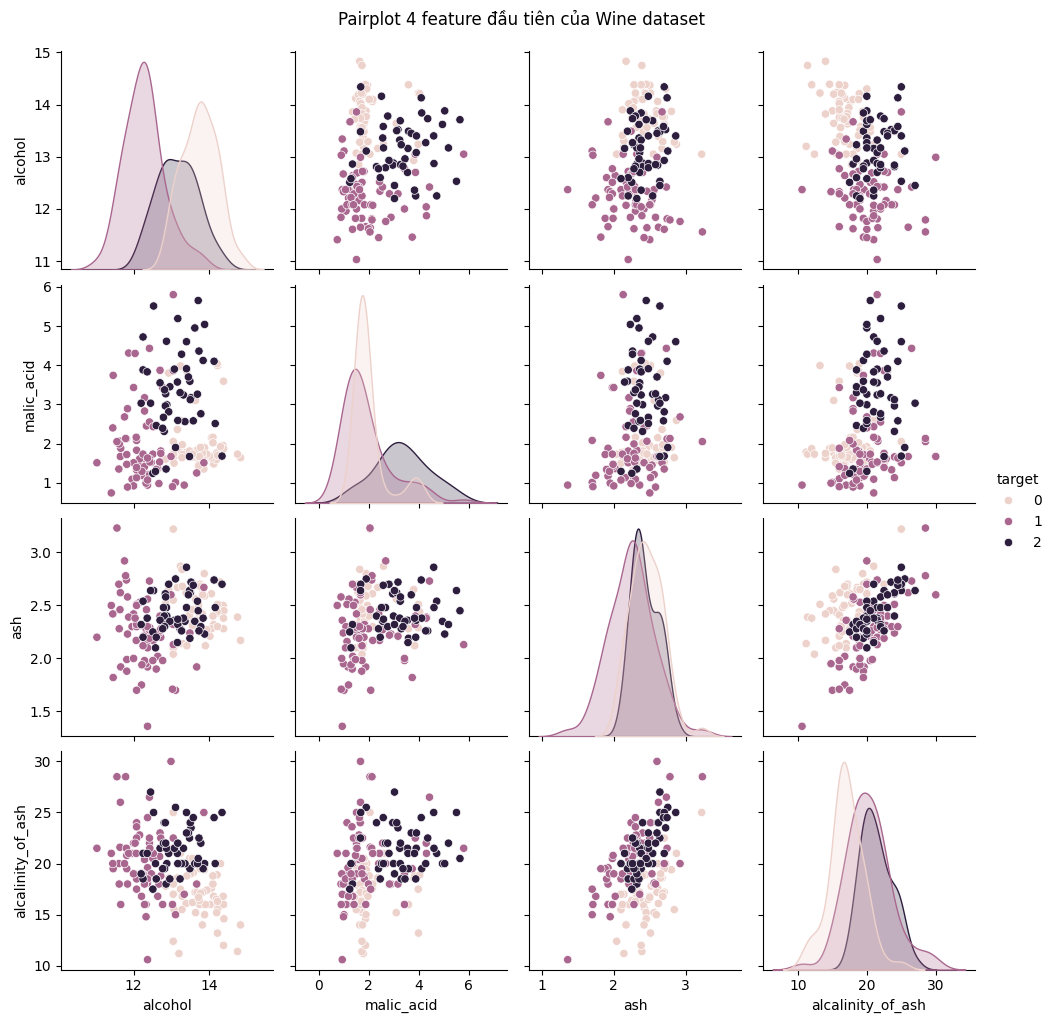

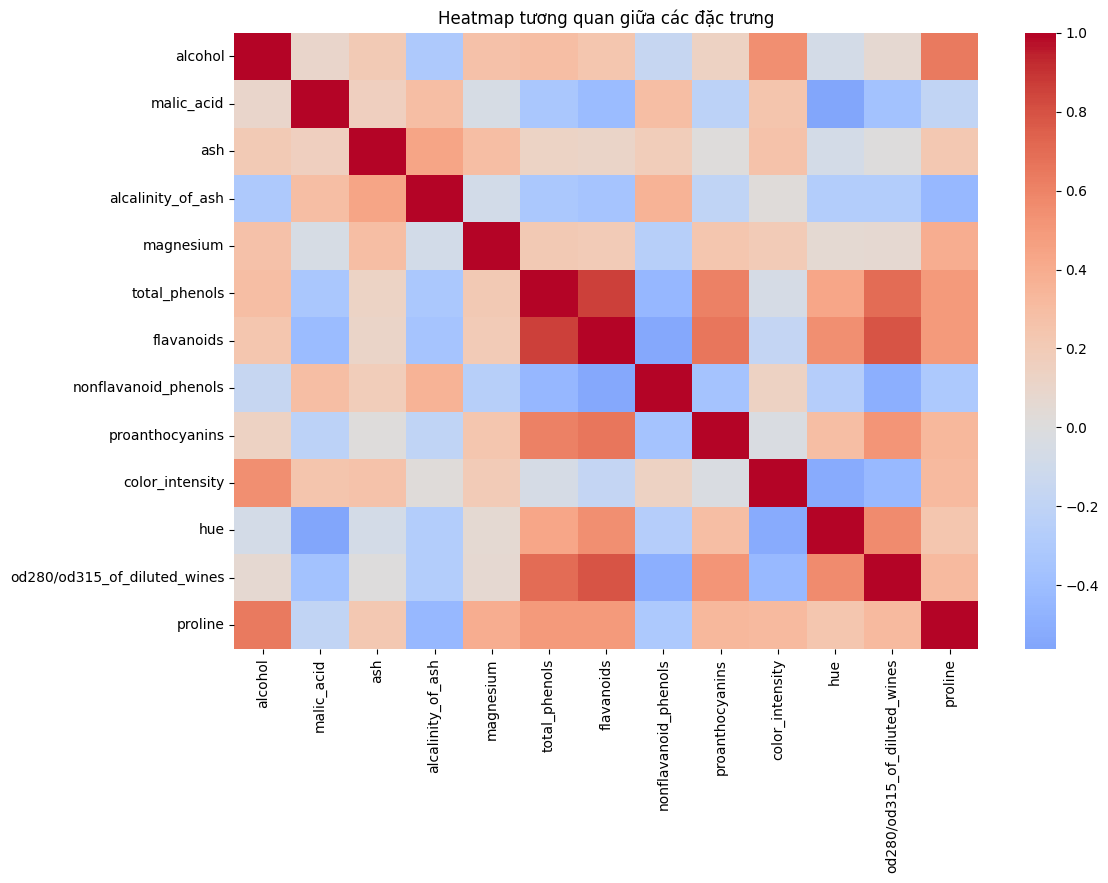

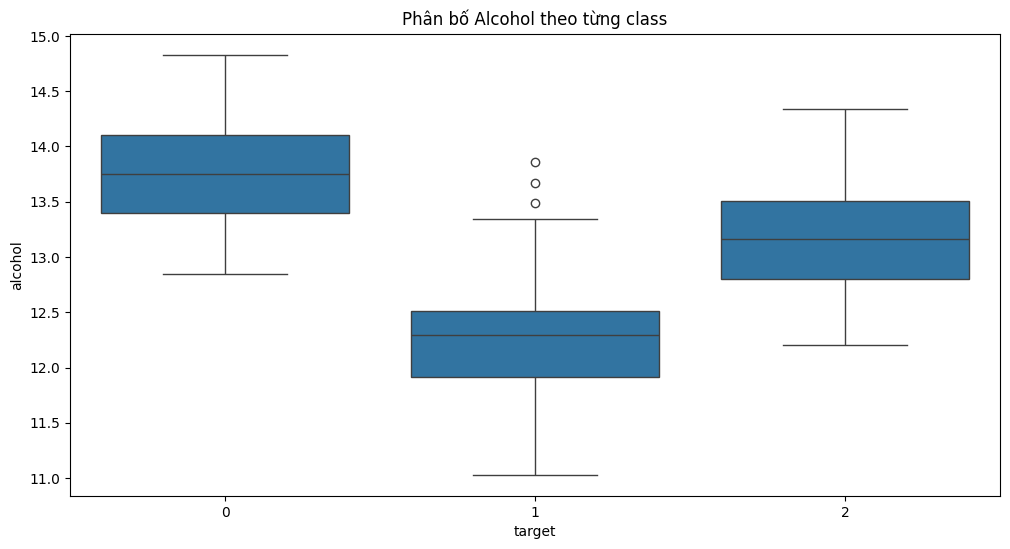

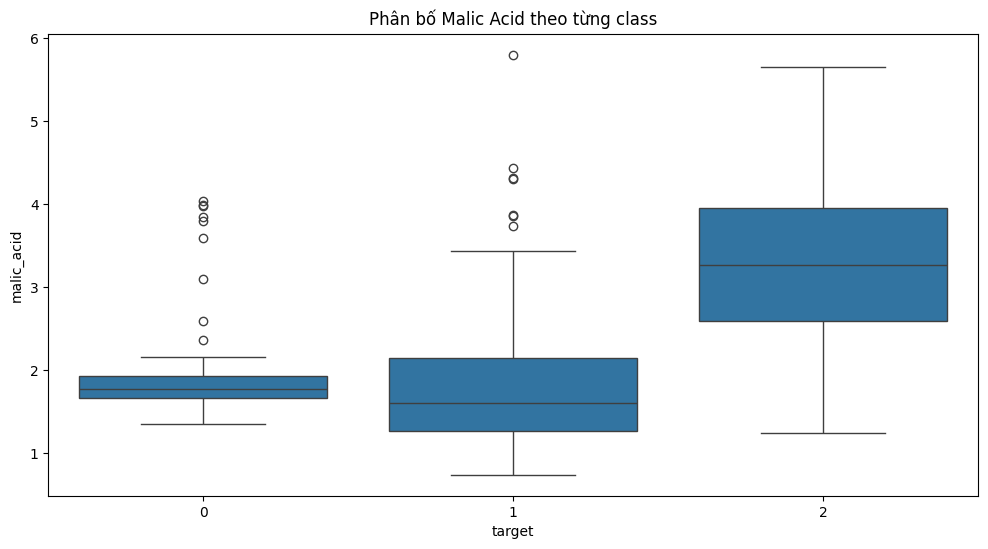

In [12]:
# Pairplot cho 4 feature đầu tiên
sns.pairplot(df.iloc[:, :4].join(df["target"]), hue="target", diag_kind="kde")
plt.suptitle("Pairplot 4 feature đầu tiên của Wine dataset", y=1.02)
plt.show()

# Heatmap tương quan giữa các feature
plt.figure(figsize=(12, 8))
corr = df[feature_names].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap tương quan giữa các đặc trưng")
plt.show()

# Boxplot một vài đặc trưng theo lớp target
plt.figure(figsize=(12, 6))
sns.boxplot(x="target", y="alcohol", data=df)
plt.title("Phân bố Alcohol theo từng class")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="target", y="malic_acid", data=df)
plt.title("Phân bố Malic Acid theo từng class")
plt.show()

Val acc before prune: 0.9166666666666666


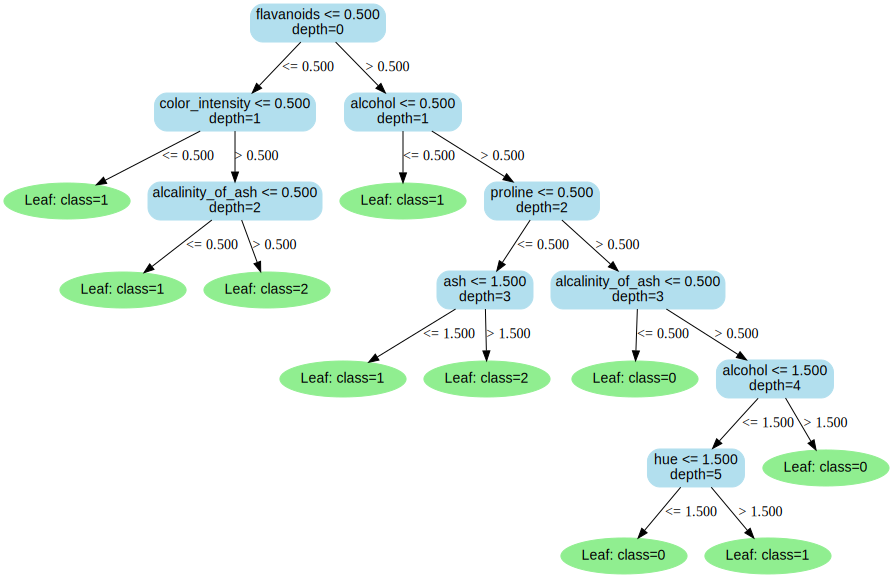

Val acc after prune: 1.0
Test acc (after prune): 0.9444444444444444


In [13]:
tree = id3(X_train, y_train, feature_indices=list(range(X_train.shape[1])),
                      max_depth=None, min_samples=2)

print("Val acc before prune:", accuracy_score(y_val, predict(tree, X_val)))
dot = tree_to_graphviz(tree, feature_names)
display(dot)

tree_pruned = reduced_error_prune(tree, X_train, y_train, X_val, y_val)
print("Val acc after prune:", accuracy_score(y_val, predict(tree_pruned, X_val)))
print("Test acc (after prune):", accuracy_score(y_test, predict(tree_pruned, X_test)))
